# Introduction
In this Notebook you can extract patterns formed between observed and latent variables as learnt from a deep generative model. Log-linear models are step-wise fit to discretized synthetic data sampled from the model. First the method is demonstrated on simulated data and then on single cell RNA-Seq data from [Tasic et al. 2016](https://www.nature.com/articles/nn.4216).

In [ ]:
# using Pkg
Pkg.add(["PyPlot","UMAP","LinearAlgebra","Distributions","Random","Flux","Zygote","SpecialFunctions","StatsBase","BoltzmannMachines","Statistics","DelimitedFiles"])
Pkg.add(url="https://github.com/ssehztirom/LogLinearModels.jl")

In [1]:
using PyPlot
using UMAP
using LinearAlgebra
using Distributions
using Random
using Flux
using Zygote
using SpecialFunctions
using LogLinearModels
using StatsBase
using BoltzmannMachines
using Statistics
using DelimitedFiles

In [2]:
include("patternextractor.jl")

makeconstraint (generic function with 2 methods)

# Code for training VAEs

In [3]:
# Principal component analysis (PCA)

function standardize2(x)
    (x .- mean(x, dims = 1)) ./ std(x, dims = 1)
end

function prcomps(mat, standardizeinput = true)
    if standardizeinput
        mat = standardize2(mat)
    end
    u,s,v = svd(mat)
    prcomps = u * Diagonal(s)
    return prcomps
end


struct VAE
	encoder
	mu
	logsigma
	decoder
end

struct VAE
    encoder
    μ_encoder
    logσ_encoder
    decoder 
end
Flux.Functors.@functor VAE

# init
function VAE(in::Int, zdim::Int; 
    hidden::Int=round(Int(in/10)), 
    act_enc::Function=tanh, 
    act_dec::Function=tanh, 
    seed::Int=1234)
    
    Random.seed!(seed)
    encoder = Dense(in, hidden, act_enc)
    μ_encoder = Dense(hidden, zdim)
    logσ_encoder = Dense(hidden, zdim)
    decoder = Chain(Dense(zdim, hidden, act_dec),
                    Dense(hidden, in, σ)
    )
    return VAE(encoder, μ_encoder, logσ_encoder, decoder)
end

(m::VAE)(x) = m.decoder(m.μ_encoder(m.encoder(x)))


# struct XYZ
#    encoder

function bernoulliloss(xhat,x)
	ce(x,y) =  y * log(x + eps()) + (1 - y) * log(1 - x + eps())
	# logpdf(b::Bernoulli,y::Bool) = y * log(b.p + eps()) + (1-y) * log(1-b.p + eps())
	# return sum(Distributions.logpdf.(Bernoulli.(xhat),x))
	return sum(ce.(xhat,x))
end

    
function normalz(mu,logsigma)
	return mu  + exp(logsigma) * randn()
end



function kullbackleiblerqp(mu,logsigma)
	return 0.5 * sum(exp.(2 .* logsigma) + mu.^2 .- 1 .- 2 .* logsigma)
end


g(x) = (h = vae.encoder(x); (vae.mu(h), vae.logsigma(h)))	

loss(x) = ((mu,logsigma) = g(x);
    (sum(bernoulliloss(vae.decoder(normalz.(mu,logsigma)),x))
        - Beta * kullbackleiblerqp(mu,logsigma)) / batchsize)

loss (generic function with 1 method)

In [4]:
function posteriorsample(x) 
    mu,logsigma = g(x)
    zs = normalz.(mu, logsigma)
    muz = vae.decoder(zs)
    return zs, muz
end

function priorsample(x) 
    mu,logsigma = g(x)
    mu = zeros(length(mu))
    logsigma = zeros(length(logsigma))
    zs = normalz.(mu, logsigma)
    muz = vae.decoder(zs)
    return zs, muz
end

priorsample (generic function with 1 method)

# Code for simulated data

In [5]:
n = 250
a = 2
b = -2

-2

In [6]:
g1c1z1 = rand(Normal(a,1),n)
g1c2z1 = rand(Normal(b,1),n)
g1c1z2 = rand(Normal(a,1),n)
g1c2z2 = rand(Normal(a,1),n)

g2c1z2 = rand(Normal(a,1),n)
g2c2z2 = rand(Normal(b,1),n)
g2c1z1 = rand(Normal(a,1),n)
g2c2z1 = rand(Normal(a,1),n)


250-element Vector{Float64}:
  0.7328341134464837
  1.1003733068497024
  2.52606949091402
  2.6806089305753513
  1.8367090102374695
  0.47230031043898535
 -0.7887268517534007
  3.8026492831190897
  1.8391482336297325
  2.9958798830561935
  2.724274580760915
  4.046069204037918
  3.6229008545128973
  ⋮
  2.9635135432903614
  2.7428520759757427
  3.6607623932048723
  2.31091680093392
  1.216086524843105
  3.943072087068514
  1.848033291172613
  4.911437470538475
  1.5788088425746452
  2.0918789391070263
  2.225987337986764
  2.5698179638207086

In [7]:
z1 = cat([g1c1z1,g1c2z1,g2c1z1,g2c2z1]...,dims=1)
z2 = cat([g1c1z2,g1c2z2,g2c1z2,g2c2z2]...,dims=1)

1000-element Vector{Float64}:
  2.2608923018402773
  3.241190087012056
  1.6670652923867704
  1.9666651033762719
  1.2825860424108946
  1.890665771858779
  0.5944312492256236
  1.0656146205650416
  1.8108320633089094
  1.2231928630746152
  1.3994050126028577
  2.4067458258938927
  1.5007399258863265
  ⋮
 -1.2787814757595872
 -0.6487950146118744
 -2.9077822373054296
 -3.060872585531432
 -2.0428449663247545
 -2.2621815633293654
 -2.3438806653383892
 -3.721140860776032
 -1.107210208498643
 -1.5673129402775021
 -3.7675472682328848
 -2.837888463257772

In [8]:
cellfactor = cat([fill(1,n),fill(2,n),fill(1,n),fill(3,n)]...,dims=1)
groupfactor = cat([fill(1,n*2),fill(2,n*2)]...,dims=1)

1000-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2
 2

In [9]:
col = ["r","deepskyblue"]
gcols = col[groupfactor]
col = ["r", "deepskyblue", "lime"]
ccols = col[cellfactor]

1000-element Vector{String}:
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 "r"
 ⋮
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"
 "lime"

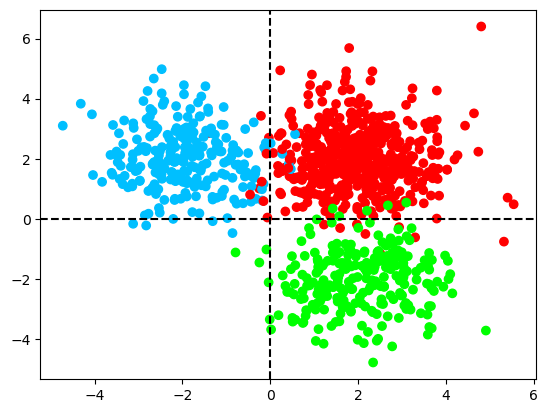

PyObject <matplotlib.lines.Line2D object at 0x20c227bb0>

In [10]:
PyPlot.scatter(z1,z2,c=ccols)
PyPlot.axhline(y = 0.0,c="black",linestyle="--")
PyPlot.axvline(x = 0.0,c="black",linestyle="--")

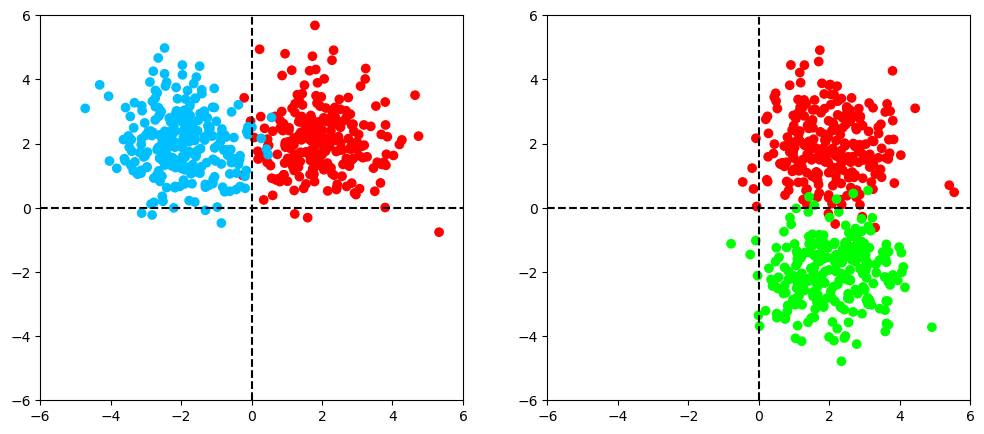

PyObject <matplotlib.lines.Line2D object at 0x20c470f70>

In [11]:
fig, ax = PyPlot.subplots(nrows=1, ncols=2, figsize=(12, 5))
g1i = groupfactor .== 1
ax[1].scatter(z1[g1i],z2[g1i],c=ccols[g1i])
ax[1][:set_ylim]([-6,6])
ax[1][:set_xlim]([-6,6])
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")
g2i = groupfactor .== 2
ax[2].scatter(z1[g2i],z2[g2i],c=ccols[g2i])
ax[2][:set_ylim]([-6,6])
ax[2][:set_xlim]([-6,6])
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

In [12]:
x = zeros(n*4,10)

1000×10 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.

In [13]:
for i=1:5
    x[:,i] = z1 + rand(Normal(0,1),n*4)
end

In [14]:
for i=6:10
    x[:,i] = z2 + rand(Normal(0,1),n*4)
end

In [15]:
x01 = convert(Array{Float64,2},ifelse.(x.>0,1,0))

1000×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0
 1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 ⋮                        ⋮                   
 1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  0.

In [16]:
noisevars = convert(Array{Float64,2},rand(1000,20) .> 0.5)

1000×20 Matrix{Float64}:
 1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  …  0.0  0.0  1.0  1.0  0.0  1.0  1.0
 0.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0     1.0  1.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  1.0  1.0  0.0  1.0     1.0  0.0  1.0  0.0  1.0  1.0  0.0
 0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0     0.0  1.0  0.0  0.0  0.0  1.0  1.0
 1.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  1.0  0.0  0.0  1.0  0.0  1.0
 1.0  0.0  1.0  1.0  0.0  1.0  1.0  0.0     1.0  1.0  0.0  0.0  0.0  1.0  1.0
 0.0  1.0  0.0  0.0  1.0  0.0  1.0  1.0     0.0  0.0  1.0  1.0  0.0  0.0  1.0
 0.0  0.0  1.0  0.0  1.0  1.0  0.0  1.0     1.0  1.0  0.0  1.0  0.0  1.0  1.0
 1.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  …  1.0  1.0  1.0  0.0  0.0  1.0  1.0
 0.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0     0.0  1.0  1.0  0.0  0.0  1.0  0.0
 1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0

In [17]:
x01 = hcat([x01,noisevars]...)

1000×30 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  0.0  0.0  1.0  1.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0     1.0  0.0  1.0  0.0  1.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  1.0  0.0  0.0  0.0  1.0  1.0
 0.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  …  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  1.0  0.0  0.0  1.0  0.0  1.0
 1.0  1.0  1.0  0.0  1.0  1.0  0.0  1.0     1.0  1.0  0.0  0.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  1.0  1.0  0.0  0.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  0.0  1.0  0.0  1.0  1.0
 1.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0  …  1.0  1.0  1.0  0.0  0.0  1.0  1.0
 1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0     0.0  1.0  1.0  0.0  0.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

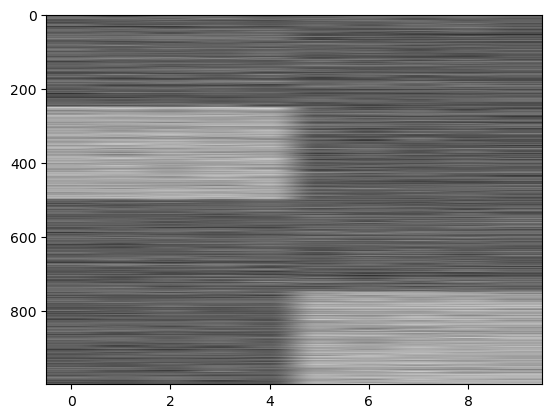

PyObject <matplotlib.image.AxesImage object at 0x20c500070>

In [18]:
PyPlot.imshow(x,aspect="auto",cmap="binary")

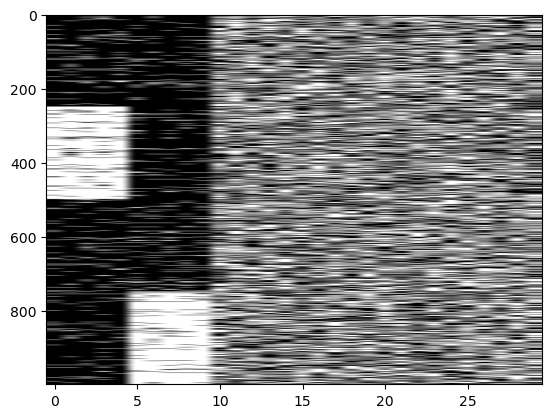

PyObject <matplotlib.image.AxesImage object at 0x20c548eb0>

In [19]:
PyPlot.imshow(x01,aspect="auto",cmap="binary")

## Simulated Data Ready, prepare for training VAE

In [20]:
n,p = size(x01)

(1000, 30)

In [21]:
randindex = Random.randperm(n);
trainidx = randindex[1:Int(round(.632*n))];
testidx = randindex[Int(round(.632*n))+1:n];
testdata = [x01[i,:]' for i in Iterators.partition(testidx,1)]; 
evalvae() = (push!(losslist,sum(lossplus.(testdata[1:10],testys[1:10]))))#;println(sum(x->sum(x.^2),Flux.params(vae.decoder))))

evalvae (generic function with 1 method)

In [22]:
testdata

368-element Vector{Adjoint{Float64, Matrix{Float64}}}:
 [0.0; 0.0; … ; 1.0; 0.0;;]
 [1.0; 1.0; … ; 0.0; 0.0;;]
 [1.0; 1.0; … ; 1.0; 0.0;;]
 [1.0; 1.0; … ; 1.0; 0.0;;]
 [1.0; 1.0; … ; 0.0; 1.0;;]
 [1.0; 1.0; … ; 0.0; 1.0;;]
 [1.0; 1.0; … ; 1.0; 0.0;;]
 [0.0; 0.0; … ; 1.0; 1.0;;]
 [1.0; 1.0; … ; 0.0; 1.0;;]
 [0.0; 0.0; … ; 0.0; 0.0;;]
 [1.0; 1.0; … ; 1.0; 0.0;;]
 [1.0; 1.0; … ; 1.0; 0.0;;]
 [1.0; 1.0; … ; 0.0; 1.0;;]
 ⋮
 [1.0; 1.0; … ; 1.0; 1.0;;]
 [1.0; 1.0; … ; 0.0; 0.0;;]
 [1.0; 1.0; … ; 0.0; 0.0;;]
 [1.0; 1.0; … ; 0.0; 1.0;;]
 [1.0; 1.0; … ; 1.0; 1.0;;]
 [0.0; 1.0; … ; 1.0; 0.0;;]
 [1.0; 1.0; … ; 1.0; 0.0;;]
 [1.0; 1.0; … ; 0.0; 1.0;;]
 [1.0; 1.0; … ; 1.0; 1.0;;]
 [1.0; 1.0; … ; 1.0; 0.0;;]
 [1.0; 1.0; … ; 0.0; 1.0;;]
 [1.0; 1.0; … ; 1.0; 0.0;;]

In [23]:
col = ["lightgrey","k"]
gcols = col[groupfactor[testidx]]
col = ["r", "deepskyblue", "lime"]
ccols = col[cellfactor[testidx]]

368-element Vector{String}:
 "deepskyblue"
 "r"
 "r"
 "lime"
 "r"
 "r"
 "r"
 "deepskyblue"
 "r"
 "deepskyblue"
 "r"
 "r"
 "r"
 ⋮
 "lime"
 "lime"
 "r"
 "lime"
 "r"
 "r"
 "r"
 "lime"
 "r"
 "lime"
 "r"
 "r"

# Train VAE

In [24]:
Random.seed!(1234)
Dh = 30
Dz = 2
epochs = 50
learningrate = 0.004
batchsize=10
Beta =1

loss(x) = ((mu,logsigma) = g(x);
    (sum(bernoulliloss(vae.decoder(normalz.(mu,logsigma)),x))
        - Beta * kullbackleiblerqp(mu,logsigma)) / batchsize)
Random.seed!(1234)
vae =  VAE(Flux.Chain(Flux.Dense(p,Dh,tanh)),
    Flux.Dense(Dh,Dz),
    Flux.Dense(Dh,Dz),
    Flux.Chain(Flux.Dense(Dz,Dh,relu),Flux.Dense(Dh,p,sigmoid)))

optimizer = ADAM(learningrate)
vaeparams = Flux.params(vae.encoder,vae.mu,vae.logsigma,vae.decoder)
losslist = []

for i = 1:25
    traindata = [x01[i,:]' for i in Iterators.partition(trainidx, batchsize)][1:(end-1)]
    idx = 0
    for x = traindata 
        idx += 1
            #println(ys)
            batch_loss, back = Flux.pullback(vaeparams) do
            -loss(x)
            end
            push!(losslist,batch_loss)
            grad = back(1f0)
            Flux.Optimise.update!(optimizer, vaeparams, grad)
    end
end




In [25]:
Random.seed!(1234)
Dh = 30
Dz = 2
epochs = 50
learningrate = 0.004
batchsize=10
Beta =1

1

In [26]:
loss(x) = ((mu,logsigma) = g(x);
    (sum(bernoulliloss(vae.decoder(normalz.(mu,logsigma)),x))
        - Beta * kullbackleiblerqp(mu,logsigma)) / batchsize)

loss (generic function with 1 method)

In [27]:
Random.seed!(1234)
vae =  VAE(Flux.Chain(Flux.Dense(p,Dh,tanh)),
    Flux.Dense(Dh,Dz),
    Flux.Dense(Dh,Dz),
    Flux.Chain(Flux.Dense(Dz,Dh,relu),Flux.Dense(Dh,p,sigmoid)))

VAE(Chain(Dense(30, 30, tanh)), Dense(30, 2), Dense(30, 2), Chain(Dense(2, 30, relu), Dense(30, 30, σ)))

In [28]:
optimizer = ADAM(learningrate)
vaeparams = Flux.params(vae.encoder,vae.mu,vae.logsigma,vae.decoder)

Params([Float32[-0.21166883 -0.036679838 … -0.09168885 0.094487116; 0.050509237 0.23434964 … 0.27464327 -0.031743303; … ; -0.02800931 -0.13444553 … 0.2145687 0.22609095; 0.1939767 0.22877489 … -0.16312665 0.2823618], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.23465197 0.22051999 … 0.07838469 -0.034903724; 0.21626312 0.045496177 … -0.36964485 0.0015206997], Float32[0.0, 0.0], Float32[-0.42893928 0.370592 … 0.11676181 -0.32878834; 0.25255343 -0.03477674 … 0.225178 0.16739601], Float32[0.0, 0.0], Float32[0.1933963 0.06880604; 0.36454853 0.33934513; … ; 0.34757817 0.2702324; 0.3253124 0.11031515], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.14380309 -0.3017917 … 0.063717805 -0.0048677; 0.09285279 -0.01082798 … -0.13923407 0.11875712; … ; -0.31188414 0.052131128 … -0.29600835 0.16998582; 0.1445122 0.17016178 … -0.30094182 0.26255414], 

Write a custom training loop

In [29]:
losslist = []
for i = 1:25
    traindata = [x01[i,:]' for i in Iterators.partition(trainidx, batchsize)][1:(end-1)]
    idx = 0
    for x = traindata 
        idx += 1
            #println(ys)
            batch_loss, back = Flux.pullback(vaeparams) do
            -loss(x)
            end
            push!(losslist,batch_loss)
            grad = back(1f0)
            Flux.Optimise.update!(optimizer, vaeparams, grad)
    end
end


# Check output from VAE

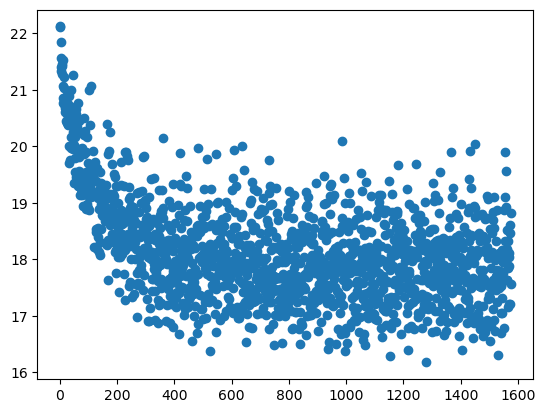

PyObject <matplotlib.collections.PathCollection object at 0x20c5b5dc0>

In [30]:
PyPlot.scatter(collect(1:length(losslist)),losslist)

## Plot expected value of latent variables

In [31]:
zs = Transpose(cat(dims=2,map(x-> x[1],g.(testdata))...))

368×2 transpose(::Matrix{Float64}) with eltype Float64:
  1.5058      0.123207
 -0.549647    1.19193
 -0.0415217   0.511469
 -1.17946    -1.16633
 -0.392466    1.22186
 -0.105383    1.0051
 -0.347966    1.21764
  1.61043    -0.200447
 -0.452464    1.22774
  1.51552     0.11358
 -0.467901    1.19624
 -0.513891    0.545332
 -0.371979    1.0966
  ⋮          
 -1.05145    -1.10758
 -1.2186     -1.25433
 -0.833437    0.0669104
 -1.04207    -1.17725
 -0.364383    1.11672
  0.239246    0.80546
 -0.435881    1.1083
 -0.956536   -1.43848
 -0.206713    0.962668
 -1.14021    -1.20452
 -0.959497   -0.15018
 -0.421986    1.24225

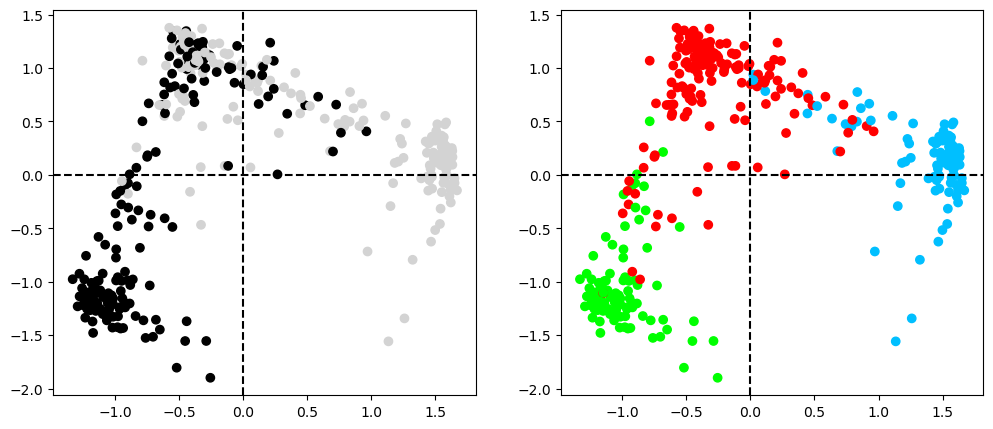

PyObject <matplotlib.lines.Line2D object at 0x214b87670>

In [32]:
fig, ax = PyPlot.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax[1].scatter(zs[:,1],zs[:,2],c=gcols)
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")
ax[2].scatter(zs[:,1],zs[:,2],c=ccols)
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

In [33]:
zs = Transpose(cat(dims=2,map(x-> x[1],posteriorsample.(testdata))...))

368×2 transpose(::Matrix{Float64}) with eltype Float64:
  1.84032     0.841739
 -1.40834     1.00062
  0.677481   -0.0883592
 -0.323438   -1.32342
 -0.190128    0.468734
 -0.0442721   1.14164
  0.0699168   0.475345
  1.26776    -0.181895
 -0.191074    1.72034
  1.49769     0.618636
 -0.0954594   1.04226
 -0.529199    0.595601
 -1.35384     1.3424
  ⋮          
 -0.0803181  -0.363343
 -1.54529    -1.73235
 -0.400625    0.504407
 -1.0911     -1.6424
 -0.614164    0.618979
  0.602051    1.43174
 -0.800478    0.643278
 -1.08113    -1.8263
 -0.193153    0.357734
 -0.441258   -1.33309
 -1.47916    -0.483499
  0.0189339   0.961077

## Left labelled according to group, right labelled according to celltype

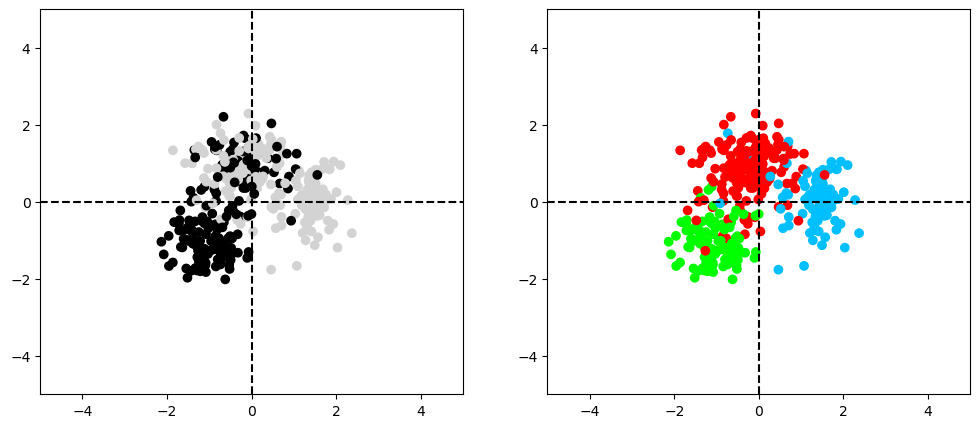

PyObject <matplotlib.lines.Line2D object at 0x214c5de20>

In [34]:
fig, ax = PyPlot.subplots(nrows=1, ncols=2, figsize=(12, 5))
scalepar = 5
ax[1].scatter(zs[:,1],zs[:,2],c=gcols)
ax[1].set_xlim(-scalepar,scalepar)
ax[1].set_ylim(-scalepar,scalepar)
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")
ax[2].scatter(zs[:,1],zs[:,2],c=ccols)
ax[2].set_xlim(-scalepar,scalepar)
ax[2].set_ylim(-scalepar,scalepar)
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

# Draw samples from trained VAE

In [35]:
vaesamples = priorsample.(vcat([testdata for i = 1:10]...))

3680-element Vector{Tuple{Vector{Float64}, Vector{Float64}}}:
 ([0.8269663245760153, -0.6543917092606906], [0.19403867051777363, 0.2642424158633385, 0.18593861414251234, 0.2100772281921409, 0.21219306453663334, 0.801487625759605, 0.8354969121133552, 0.790210821468038, 0.8336626542184088, 0.8318566067787859  …  0.5154272430750375, 0.5391405206045854, 0.5038843696089585, 0.5029050809770714, 0.4734019925085631, 0.5049495914435516, 0.5138461009643914, 0.5163633837691749, 0.514225830570905, 0.5124567537903262])
 ([0.2961307245636859, -1.1629161916276305], [0.5523369299170825, 0.5925878110865471, 0.5440287620018139, 0.5550684938139986, 0.6449717521823128, 0.22853598336614253, 0.34168711990533135, 0.2758320367572918, 0.28550342083782, 0.3020858836805545  …  0.5305960608465035, 0.5222838996049823, 0.507896463515995, 0.5212375260809831, 0.5297379509545563, 0.5090111056926837, 0.5001275082428132, 0.49167632151361906, 0.5109221720821037, 0.4872817108843669])
 ([0.4724494433146802, -1.780194269978

In [36]:
vaepostsamples = posteriorsample.(vcat([testdata for i = 1:10]...))

3680-element Vector{Tuple{Matrix{Float64}, Matrix{Float64}}}:
 ([1.8353711264822736; 0.7800352990971723;;], [0.04794982468410362; 0.06204802831855521; … ; 0.4529386257624529; 0.5402486428153755;;])
 ([0.5742368585076437; 1.3505459509499655;;], [0.8664991100530474; 0.8205686629071953; … ; 0.47304813615016883; 0.5429063578791363;;])
 ([-0.6191098167190703; -0.04783973415639031;;], [0.9777065339603949; 0.9666525511105166; … ; 0.4724151697202361; 0.4688703058394784;;])
 ([-1.6727070295972477; -0.8043934493246339;;], [0.9954336660121759; 0.9904525471696292; … ; 0.4156315611597643; 0.41081965524362435;;])
 ([-1.0857647516783573; 0.8494528248753488;;], [0.9960505845747224; 0.9923103021469775; … ; 0.4798939063533953; 0.4829819269313013;;])
 ([-0.23658243351980648; 1.6301521585778342;;], [0.9887496270063667; 0.9785363367502656; … ; 0.5024833383622647; 0.5480851432300285;;])
 ([-0.784239539206858; 1.3296414031259376;;], [0.9954722497492027; 0.9907679760981011; … ; 0.5030951502353611; 0.511733404

In [37]:
vaesamples = vaepostsamples

3680-element Vector{Tuple{Matrix{Float64}, Matrix{Float64}}}:
 ([1.8353711264822736; 0.7800352990971723;;], [0.04794982468410362; 0.06204802831855521; … ; 0.4529386257624529; 0.5402486428153755;;])
 ([0.5742368585076437; 1.3505459509499655;;], [0.8664991100530474; 0.8205686629071953; … ; 0.47304813615016883; 0.5429063578791363;;])
 ([-0.6191098167190703; -0.04783973415639031;;], [0.9777065339603949; 0.9666525511105166; … ; 0.4724151697202361; 0.4688703058394784;;])
 ([-1.6727070295972477; -0.8043934493246339;;], [0.9954336660121759; 0.9904525471696292; … ; 0.4156315611597643; 0.41081965524362435;;])
 ([-1.0857647516783573; 0.8494528248753488;;], [0.9960505845747224; 0.9923103021469775; … ; 0.4798939063533953; 0.4829819269313013;;])
 ([-0.23658243351980648; 1.6301521585778342;;], [0.9887496270063667; 0.9785363367502656; … ; 0.5024833383622647; 0.5480851432300285;;])
 ([-0.784239539206858; 1.3296414031259376;;], [0.9954722497492027; 0.9907679760981011; … ; 0.5030951502353611; 0.511733404

In [38]:
zs = Transpose(cat(dims=2,map(x-> x[1],vaesamples)...))
xs = Transpose(cat(dims=2,map(x-> x[2],vaesamples)...))

3680×30 transpose(::Matrix{Float64}) with eltype Float64:
 0.0479498   0.062048   0.0419775   …  0.471189  0.452939  0.540249
 0.866499    0.820569   0.787402       0.437106  0.473048  0.542906
 0.977707    0.966653   0.955122       0.474146  0.472415  0.46887
 0.995434    0.990453   0.989858       0.444571  0.415632  0.41082
 0.996051    0.99231    0.986484       0.418339  0.479894  0.482982
 0.98875     0.978536   0.968003    …  0.398137  0.502483  0.548085
 0.995472    0.990768   0.984221       0.397806  0.503095  0.511733
 0.00517493  0.0207258  0.00567877     0.517667  0.560029  0.517427
 0.993851    0.988765   0.981099       0.427502  0.483548  0.487407
 0.0357014   0.0763285  0.0353028      0.518578  0.522184  0.519194
 0.99693     0.99328    0.988121    …  0.38209   0.507214  0.517847
 0.992602    0.986792   0.978533       0.439053  0.475353  0.479206
 0.991348    0.983586   0.974228       0.414513  0.502405  0.514595
 ⋮                                  ⋱                      


# Dichotomize samples 
You could also use the dichotomize function to cut the samples at a given quantile if you trained the VAE with count data.

In [39]:
zsbin = ifelse.(zs.>0,1,0)
xsbin = float.(xs .> rand(size(xs)...))

3680×30 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  …  1.0  0.0  1.0  1.0  0.0  1.0  0.0
 1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0     1.0  0.0  1.0  0.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0     1.0  1.0  0.0  1.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0     1.0  1.0  1.0  1.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  0.0  0.0  1.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0     1.0  1.0  0.0  1.0  1.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  0.0  0.0  0.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0     0.0  0.0  1.0  0.0  0.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0     1.0  0.0  1.0  0.0  1.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

## Infer Patterns between latent variables and observed variables with log-linear models

In [40]:
nvars = 12

12

In [41]:
res = select_k_variables(nvars,[converttoleveldata([xsbin,zsbin])],evolution=true)

([1811.2818860798247, 1353.6109266424724, 538.8339531613593, 346.8813874053554, 264.3229352207918, 194.36002256730166, 146.4278823783977, 132.54225657303658, 118.0697621170282, 123.22195600980972, 78.49195049963703, 101.21256361920189], [6, 1, 8, 2, 10, 5, 9, 4, 3, 7, 29, 20], Any[[1538.1667071685172 10.746268186889537; 1419.7027944552372 3.7345230930830553; … ; 1.3585487205555822 0.11907716908323174; 20.102026655549025 8.5729477870549], [1353.6109266424724 269.42377938617074; 1244.052768212739 202.06864998764115; … ; 0.03869399372921878 7.734257638778459; 12.43545919782963 1.932116134073146], [0.0 0.0; 346.2880577253631 16.273194433064276; … ; 2.2967009357563093 22.114839567514828; 11.35719402989428 5.0863767659819175], [0.0 0.0; 346.8813874053554 30.819879406683466; … ; 12.373896344885454 31.003604463664765; 15.067019006668119 9.855441912426908], [0.0 0.0; 0.0 0.0; … ; 27.911938070961057 36.6631692170438; 17.05240849336768 15.561712731628697], [0.0 0.0; 0.0 0.0; … ; 30.08112459329319

## Inspect the G-Squared matrix for each selected variable
The Matrix indicates the G-Squared statistic used for selecting a variable at a given iteration (here 12 iterations evaluated).
In the below stated example, g-squared matrix for iteration 6 (based on which the 6th variable is selected) is shown.

In [42]:
res[1]

12-element Vector{Float64}:
 1811.2818860798247
 1353.6109266424724
  538.8339531613593
  346.8813874053554
  264.3229352207918
  194.36002256730166
  146.4278823783977
  132.54225657303658
  118.0697621170282
  123.22195600980972
   78.49195049963703
  101.21256361920189

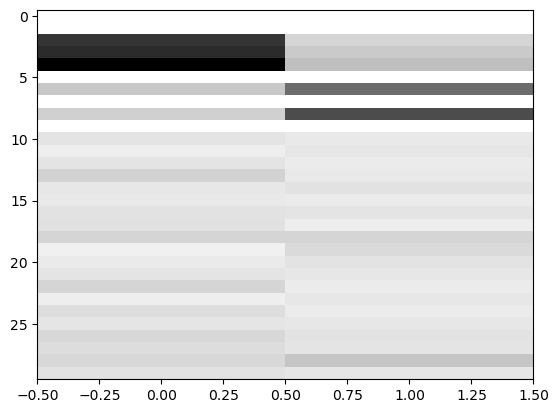

PyObject <matplotlib.image.AxesImage object at 0x2171d43d0>

In [43]:
ax = PyPlot.imshow(res[3][6],aspect="auto",cmap="binary")

## Here we infer the labels for the synthetic observations drawn from a VAE based on testdata.

In [44]:
yhat = annotatesamplesbypattern(Transpose(hcat(testdata...)),xsbin[1:500,:],res[2],ccols)

500-element Vector{String}:
 "r"
 "deepskyblue"
 "lime"
 "lime"
 "deepskyblue"
 "r"
 "r"
 "deepskyblue"
 "r"
 "deepskyblue"
 "r"
 "r"
 "r"
 ⋮
 "deepskyblue"
 "lime"
 "deepskyblue"
 "deepskyblue"
 "deepskyblue"
 "lime"
 "r"
 "r"
 "lime"
 "r"
 "lime"
 "r"

## Here we inspect how synthetic observations were labeled

In [45]:
pzs = zs[1:500,:]

500×2 Matrix{Float64}:
  1.83537     0.780035
  0.574237    1.35055
 -0.61911    -0.0478397
 -1.67271    -0.804393
 -1.08576     0.849453
 -0.236582    1.63015
 -0.78424     1.32964
  2.0496     -1.26169
 -0.903198    0.782839
  1.43365    -0.667955
 -0.87223     1.54306
 -0.895174    0.58959
 -0.533811    1.18865
  ⋮          
  0.571737    0.35067
 -0.847953   -0.476983
  1.5283     -0.123624
 -0.253548   -0.573773
  1.62638     0.0423028
 -0.19164    -2.17828
 -0.0341529   2.07734
 -1.43512     1.0267
  0.0542392   0.807524
 -0.672457    0.466524
 -0.813512   -1.24878
 -0.191802   -1.7923

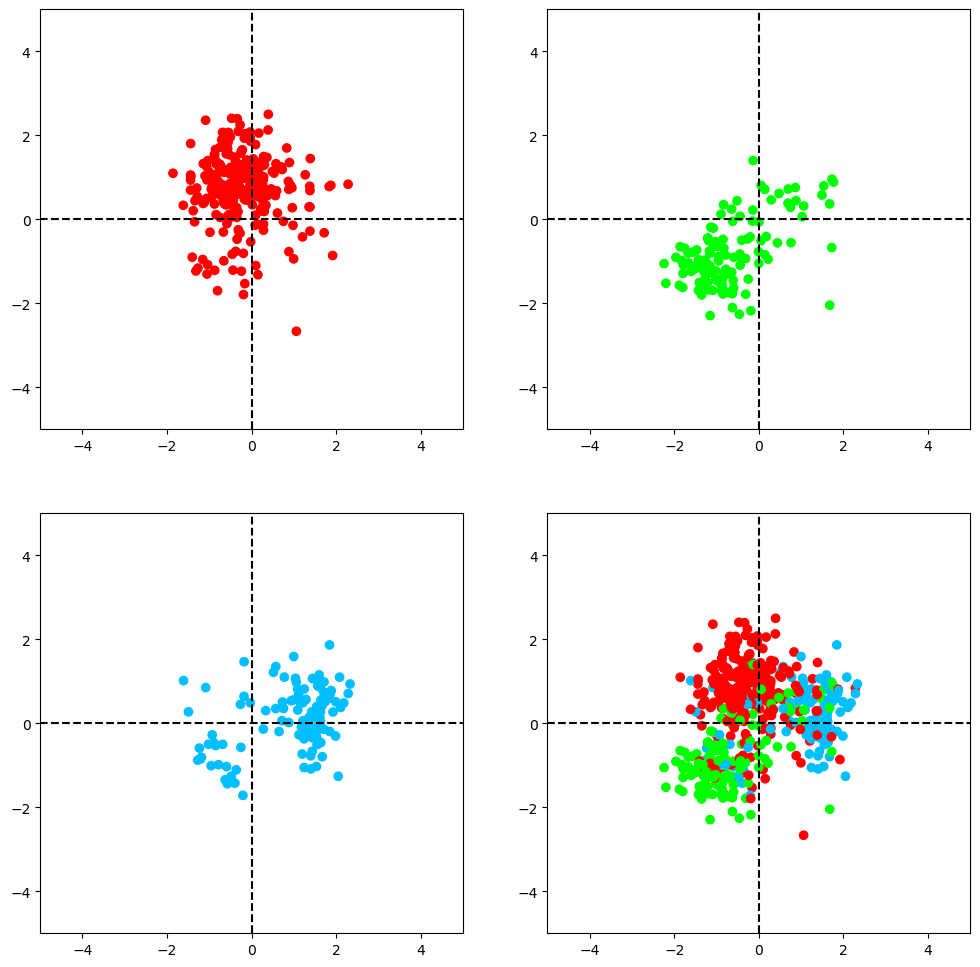

PyObject <matplotlib.lines.Line2D object at 0x21730bf40>

In [46]:
fig, ax = PyPlot.subplots(nrows=2, ncols=2, figsize=(12, 12))
scalepar = 5
ax[1].scatter(pzs[yhat.=="r",1],pzs[yhat.=="r",2],c=yhat[yhat.=="r"])
ax[1].set_xlim(-scalepar,scalepar)
ax[1].set_ylim(-scalepar,scalepar)
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")

ax[2].scatter(pzs[yhat.=="deepskyblue",1],pzs[yhat.=="deepskyblue",2],c=yhat[yhat.=="deepskyblue"])
ax[2].set_xlim(-scalepar,scalepar)
ax[2].set_ylim(-scalepar,scalepar)
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

ax[3].scatter(pzs[yhat.=="lime",1],pzs[yhat.=="lime",2],c=yhat[yhat.=="lime"])
ax[3].set_xlim(-scalepar,scalepar)
ax[3].set_ylim(-scalepar,scalepar)
ax[3].axhline(y = 0.0,c="black",linestyle="--")
ax[3].axvline(x = 0.0,c="black",linestyle="--")

ax[4].scatter(pzs[:,1],pzs[:,2],c=yhat)
ax[4].set_xlim(-scalepar,scalepar)
ax[4].set_ylim(-scalepar,scalepar)
ax[4].axhline(y = 0.0,c="black",linestyle="--")
ax[4].axvline(x = 0.0,c="black",linestyle="--")

## Now with Tasic et al. data

In [47]:
x = readdlm("data/single_cell_mat.txt",'\t')'

1525×180 adjoint(::Matrix{Float64}) with eltype Float64:
    0.0          0.0        64.0152    …  89572.3       0.0  0.0  0.0
    0.0       3379.97      466.997        17764.9       0.0  0.0  0.0
 1827.33         1.84508     0.0              0.0       0.0  0.0  0.0
    0.0          4.38998    15.9466       57210.2       0.0  0.0  0.0
    0.0          0.0       175.019        62089.7       0.0  0.0  0.0
   73.3637       0.398716    0.0       …     16.7461    0.0  0.0  0.0
  937.232        0.435715    0.0             20.9143    0.0  0.0  0.0
 2374.52         0.470643    0.0              0.941285  0.0  0.0  0.0
    0.0          0.0         0.950019         0.0       0.0  0.0  0.0
    0.799776     0.0         0.399888         9.59731   0.0  0.0  0.0
  250.506        0.0         0.0       …      0.0       0.0  0.0  0.0
  497.253        0.0        12.8967           0.0       0.0  0.0  0.0
    0.0          4.62896     0.0          49361.4       0.0  0.0  0.514329
    ⋮                       

In [48]:
x01 = dichotomize(x)

1525×180 Matrix{Float64}:
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  …  1.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0     1.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0  …  1.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0     1.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0     1.0  1.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0     1.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.

In [49]:
n,p = size(x01)
randindex = Random.randperm(n);
trainidx = randindex[1:Int(round(.632*n))];
testidx = randindex[Int(round(.632*n))+1:n];
testdata = [x01[i,:]' for i in Iterators.partition(testidx,1)]; 
evalvae() = (push!(losslist,sum(lossplus.(testdata[1:10],testys[1:10]))))#;println(sum(x->sum(x.^2),Flux.params(vae.decoder))))

evalvae (generic function with 1 method)

In [50]:
Random.seed!(1234)
Dh = 30
Dh2 = 10
Dz = 2
epochs = 500
learningrate = 0.004
batchsize=10
Beta =1

loss(x) = ((mu,logsigma) = g(x);
    (sum(bernoulliloss(vae.decoder(normalz.(mu,logsigma)),x))
        - Beta * kullbackleiblerqp(mu,logsigma)) / batchsize)
Random.seed!(1234)
vae =  VAE(Flux.Chain(Flux.Dense(p,Dh,tanh),Flux.Dense(Dh,Dh2,tanh)),
    Flux.Dense(Dh2,Dz),
    Flux.Dense(Dh2,Dz),
    Flux.Chain(Flux.Dense(Dz,Dh,relu),Flux.Dense(Dh,p,sigmoid)))

optimizer = ADAM(learningrate)
vaeparams = Flux.params(vae.encoder,vae.mu,vae.logsigma,vae.decoder)
losslist = []

for i = 1:25
    traindata = [x01[i,:]' for i in Iterators.partition(trainidx, batchsize)][1:(end-1)]
    idx = 0
    for x = traindata 
        idx += 1
            #println(ys)
            batch_loss, back = Flux.pullback(vaeparams) do
            -loss(x)
            end
            push!(losslist,batch_loss)
            grad = back(1f0)
            Flux.Optimise.update!(optimizer, vaeparams, grad)
    end
end




In [51]:
vaesamples = priorsample.(vcat([testdata for i = 1:5]...))

2805-element Vector{Tuple{Vector{Float64}, Vector{Float64}}}:
 ([1.3596261370724443, 1.2490688929677063], [0.9363829402396368, 0.01927776119286933, 0.28061093957349886, 0.21794461703544316, 0.05119531287077134, 0.608407003875518, 0.004982730938668921, 0.2795827123329808, 0.49469583576732623, 0.0071638378175214075  …  0.0005087997634012747, 0.019898356280452147, 0.008385421523283065, 0.0886285222984372, 0.10195114850732397, 0.0075300462171203515, 0.06324027937005952, 0.00042831452512481695, 0.000425409651706142, 0.00669864379621794])
 ([1.0606884911744159, 1.1929644078558859], [0.9207991350116029, 0.03341003878990266, 0.2818686381178798, 0.2560765116895359, 0.04811568972314398, 0.6504779059220156, 0.00923049163080936, 0.3153648526781733, 0.5097112454384743, 0.010514842987478843  …  0.0008883424327430064, 0.01949901332208292, 0.012668257967184801, 0.10083806369278053, 0.14437889444484409, 0.010109594196584977, 0.07038301934353187, 0.0009325926531174861, 0.0009947227000593377, 0.009977229

In [52]:
length(vaesamples)

2805

In [53]:
zs = Transpose(cat(dims=2,map(x-> x[1],vaesamples)...))
xs = Transpose(cat(dims=2,map(x-> x[2],vaesamples)...))

2805×180 transpose(::Matrix{Float64}) with eltype Float64:
 0.936383     0.0192778  0.280611  0.217945    …  0.00042541   0.00669864
 0.920799     0.03341    0.281869  0.256077       0.000994723  0.00997723
 0.68081      0.607163   0.301223  0.258983       0.0868848    0.0753408
 0.456773     0.364483   0.515798  0.106896       0.0147745    0.0449409
 0.00028609   0.3951     0.984868  0.0033015      8.6473e-5    0.00321057
 0.730734     0.498556   0.260482  0.274083    …  0.0459981    0.0337928
 0.717889     0.420002   0.357928  0.245024       0.0457933    0.0779666
 0.769447     0.250094   0.389248  0.131857       0.00904104   0.0459999
 0.000305935  0.443044   0.975218  0.00586235     0.000221306  0.00388545
 0.254373     0.282434   0.67023   0.0389449      0.0023408    0.023803
 0.799076     0.286864   0.315384  0.315041    …  0.0255482    0.0515037
 0.204113     0.245688   0.722639  0.0247891      0.000981183  0.0179593
 0.92561      0.0381083  0.243107  0.370179       0.00147716  

In [54]:
zsbin = ifelse.(zs.>0,1,0)
xsbin = float.(xs .> rand(size(xs)...))

2805×180 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  …  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0     1.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0     1.0  1.0  0.0  1.0  0.0  0.0  0.0
 1.0  0.0  1.0  0.0  0.0  1.0  0.0  0.

In [55]:
nvars = 8

8

In [548]:
y = readdlm("data/celltype.txt")[:,1]

1525-element Vector{Any}:
 "Vip"
 "Vip"
 "L4"
 "Vip"
 "Vip"
 "L2/3"
 "L2"
 "L2/3"
 "L4"
 "L2"
 "Pvalb"
 "L2/3"
 "Vip"
 ⋮
 "Pvalb"
 "Pvalb"
 "Pvalb"
 "Pvalb"
 "Pvalb"
 "Pvalb"
 "Vip"
 "Vip"
 "Vip"
 "Vip"
 "Vip"
 "Vip"

## Select variables

In [57]:
res = select_k_variables(nvars,[converttoleveldata([xsbin,zsbin])],evolution=true)

([989.3942009587754, 671.7826763069547, 443.02598187943374, 326.59163225790627, 298.8640818905589, 220.2317522161224, 205.24480182438288, 192.77411273925526], [150, 1, 155, 84, 37, 88, 27, 71], Any[[195.13648331026354 564.6522701291126; 352.2979314379788 5.5146939843502025; … ; 52.88374120329541 25.77486723743475; 12.21736010736889 7.966667574049151], [121.02438885570677 671.7826763069547; 112.16933179753849 76.91958338923304; … ; 20.124117413459594 19.045940009386232; 2.762259374497405 8.010959697558517], [0.0 0.0; 92.53416328961616 35.1339511002971; … ; 24.002697402211684 25.352967782914387; 5.304264144042568 8.478703296167563], [0.0 0.0; 97.43795213048836 45.27411688536644; … ; 30.15095018843738 24.32097662749095; 10.472784893866914 11.098203038942772], [0.0 0.0; 74.38720722240154 48.13005254657941; … ; 23.577350886893562 29.503678340351254; 11.33008501946715 21.580123298387484], [0.0 0.0; 86.49131252301557 57.46530896699206; … ; 29.752113951514772 27.03102099197809; 24.865717826079

## Annotate synthetic observations

In [58]:
yhat = annotatesamplesbypattern(x01,xsbin[1:1000,:],res[2],y)

1000-element Vector{String}:
 "Sst"
 "L6a"
 "L6a"
 "Pvalb"
 "Vip"
 "Pvalb"
 "L5a"
 "L6a"
 "Vip"
 "Vip"
 "L5b"
 "Vip"
 "L2"
 ⋮
 "L6a"
 "Sst"
 "L6a"
 "Pvalb"
 "L6a"
 "L6a"
 "Sst"
 "Vip"
 "Pvalb"
 "L5a"
 "L6a"
 "Pvalb"

## Compute principal components of synthetic data for plotting

In [59]:
pcs = prcomps(xsbin[1:1000,:])[:,1:2]

1000×2 Matrix{Float64}:
 -3.60474    0.769283
 -3.50351    0.469584
 -1.94803   -1.30422
  0.694116   1.87377
  3.35716    2.70503
 -0.447035  -2.80334
 -4.04565   -0.336949
 -2.1724     0.301394
  4.60085    1.7998
  2.26487    2.06627
 -2.40964    0.420734
  2.09403    2.97918
 -2.37223   -0.157272
  ⋮         
 -4.12056    0.126528
  4.50796    3.23309
 -1.81566    3.32193
 -0.231934  -4.78918
 -0.86264    1.36703
 -0.880161   3.15432
  0.606527   1.15161
  3.78189   -1.12224
  3.28103    0.228567
 -3.88256   -2.56323
 -2.44487   -0.00134725
  0.312218  -2.44707

In [60]:
md = Dict(
    "L4"    => "turquoise",
  "Vip"   => "darkviolet",
  "Sst"   => "gold",
  "L5a"   => "forestgreen",
  "Pvalb" => "orangered",
  "L2"    => "green",
  "L5b"   => "lightgrey",
  "Smad3" => "lightgrey",
  "Igtp"  => "lightgrey",
  "L6b"   => "lightgrey",
  "L2/3"  => "lightgrey",
  "L6a"   => "lightgrey",
  "Sncg"  => "lightgrey",
  "Ndnf"  => "lightgrey",
  "L5"    => "lightgrey"
)

Dict{String, String} with 15 entries:
  "L4"    => "turquoise"
  "Vip"   => "darkviolet"
  "Sst"   => "gold"
  "L2/3"  => "lightgrey"
  "L5a"   => "forestgreen"
  "Pvalb" => "orangered"
  "L2"    => "green"
  "L5b"   => "lightgrey"
  "L6a"   => "lightgrey"
  "Smad3" => "lightgrey"
  "Sncg"  => "lightgrey"
  "Igtp"  => "lightgrey"
  "Ndnf"  => "lightgrey"
  "L6b"   => "lightgrey"
  "L5"    => "lightgrey"

In [61]:
cols = [md[i] for i = y]

1525-element Vector{String}:
 "darkviolet"
 "darkviolet"
 "turquoise"
 "darkviolet"
 "darkviolet"
 "lightgrey"
 "green"
 "lightgrey"
 "turquoise"
 "green"
 "orangered"
 "lightgrey"
 "darkviolet"
 ⋮
 "orangered"
 "orangered"
 "orangered"
 "orangered"
 "orangered"
 "orangered"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "darkviolet"

In [62]:
hatcols = [md[i] for i = yhat]

1000-element Vector{String}:
 "gold"
 "lightgrey"
 "lightgrey"
 "orangered"
 "darkviolet"
 "orangered"
 "forestgreen"
 "lightgrey"
 "darkviolet"
 "darkviolet"
 "lightgrey"
 "darkviolet"
 "green"
 ⋮
 "lightgrey"
 "gold"
 "lightgrey"
 "orangered"
 "lightgrey"
 "lightgrey"
 "gold"
 "darkviolet"
 "orangered"
 "forestgreen"
 "lightgrey"
 "orangered"

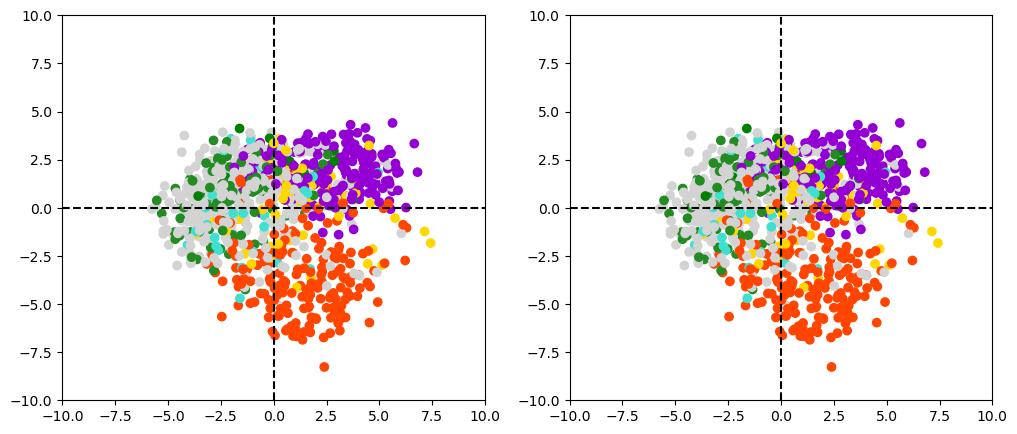

PyObject <matplotlib.lines.Line2D object at 0x218c00a30>

In [63]:
fig, ax = PyPlot.subplots(nrows=1, ncols=2, figsize=(12, 5))
scalepar = 10
ax[1].scatter(pcs[:,1],pcs[:,2],c=hatcols)
ax[1].set_xlim(-scalepar,scalepar)
ax[1].set_ylim(-scalepar,scalepar)
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")
ax[2].scatter(pcs[:,1],pcs[:,2],c=hatcols)
ax[2].set_xlim(-scalepar,scalepar)
ax[2].set_ylim(-scalepar,scalepar)
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

## Plotting separately for individual cell types

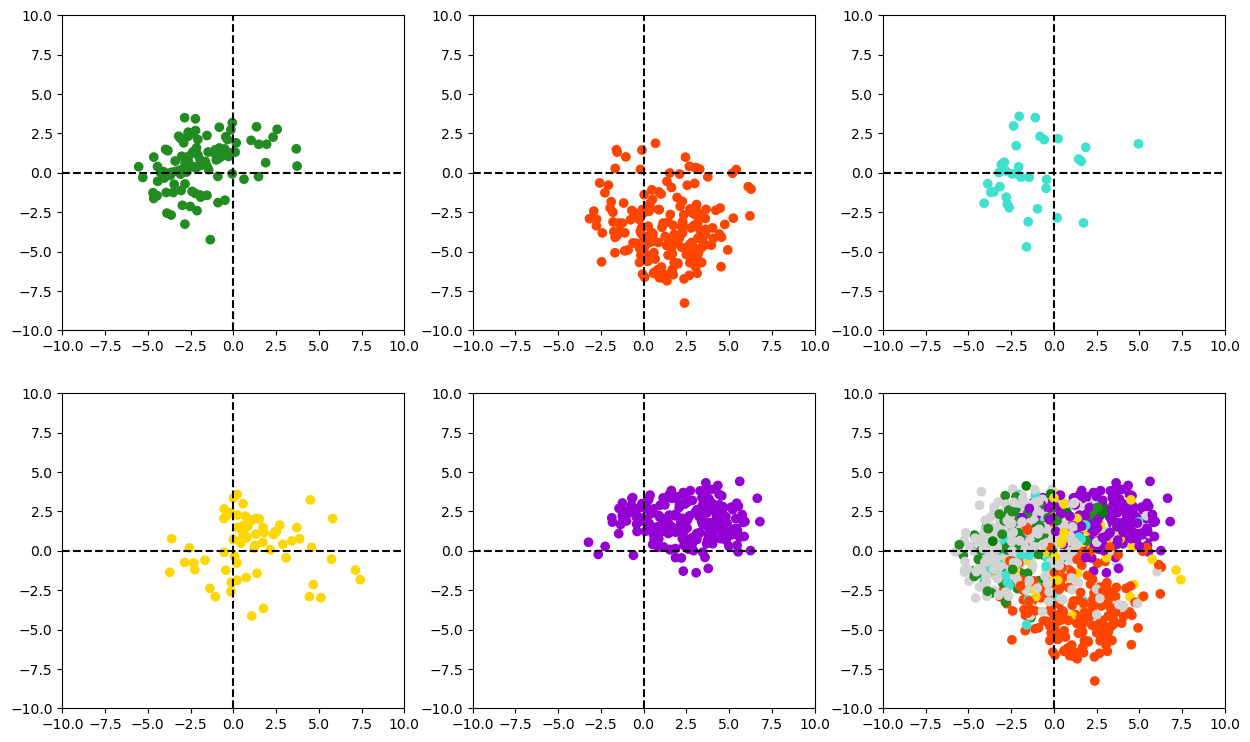

PyObject <matplotlib.lines.Line2D object at 0x218e108e0>

In [64]:
fig, ax = PyPlot.subplots(nrows=2, ncols=3, figsize=(15, 9))
scalepar = 10
ax[1].scatter(pcs[hatcols.=="forestgreen",1],pcs[hatcols.=="forestgreen",2],c=hatcols[hatcols.=="forestgreen"])
ax[1].set_xlim(-scalepar,scalepar)
ax[1].set_ylim(-scalepar,scalepar)
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")

ax[2].scatter(pcs[hatcols.=="gold",1],pcs[hatcols.=="gold",2],c=hatcols[hatcols.=="gold"])
ax[2].set_xlim(-scalepar,scalepar)
ax[2].set_ylim(-scalepar,scalepar)
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

ax[3].scatter(pcs[hatcols.=="orangered",1],pcs[hatcols.=="orangered",2],c=hatcols[hatcols.=="orangered"])
ax[3].set_xlim(-scalepar,scalepar)
ax[3].set_ylim(-scalepar,scalepar)
ax[3].axhline(y = 0.0,c="black",linestyle="--")
ax[3].axvline(x = 0.0,c="black",linestyle="--")

ax[4].scatter(pcs[hatcols.=="darkviolet",1],pcs[hatcols.=="darkviolet",2],c=hatcols[hatcols.=="darkviolet"])
ax[4].set_xlim(-scalepar,scalepar)
ax[4].set_ylim(-scalepar,scalepar)
ax[4].axhline(y = 0.0,c="black",linestyle="--")
ax[4].axvline(x = 0.0,c="black",linestyle="--")

ax[5].scatter(pcs[hatcols.=="turquoise",1],pcs[hatcols.=="turquoise",2],c=hatcols[hatcols.=="turquoise"])
ax[5].set_xlim(-scalepar,scalepar)
ax[5].set_ylim(-scalepar,scalepar)
ax[5].axhline(y = 0.0,c="black",linestyle="--")
ax[5].axvline(x = 0.0,c="black",linestyle="--")

ax[6].scatter(pcs[:,1],pcs[:,2],c=hatcols)
ax[6].set_xlim(-scalepar,scalepar)
ax[6].set_ylim(-scalepar,scalepar)
ax[6].axhline(y = 0.0,c="black",linestyle="--")
ax[6].axvline(x = 0.0,c="black",linestyle="--")

In [66]:
using Pkg 
Pkg.add(url="https://github.com/maren-ha/scVI.jl")
using scVI 

     Cloning git-repo `https://github.com/maren-ha/scVI.jl`
    Updating git-repo `https://github.com/maren-ha/scVI.jl`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed OpenSSL_jll ─ v1.1.17+0
   Installed HDF5_jll ──── v1.12.2+1
   Installed HDF5 ──────── v0.16.11
┌ Warning: The active manifest file at `/Users/moritz/Manifest.toml` has an old format that is being maintained.
│ To update to the new format run `Pkg.upgrade_manifest()` which will upgrade the format without re-resolving.
└ @ Pkg.Types /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.7/Pkg/src/manifest.jl:287
    Updating `~/Project.toml`
  [add38077] + scVI v0.1.0 `https://github.com/maren-ha/scVI.jl#main`
    Updating `~/Manifest.toml`
  [f67ccb44] + HDF5 v0.16.11
  [add38077] + scVI v0.1.0 `https://github.com/maren-ha/scVI.jl#main`
  [0234f1f7] + HDF5_jll v1.12.2+1
  [458c3c95] + OpenSSL_jll v1.1.17+0
    Building HDF5 → `~/.julia/scrat

In [295]:
# load cortex data
adata = load_cortex(@__DIR__) # (or init_cortex_from_url())

AnnData object with a countmatrix with 3005 cells and 19972 genes
   unique celltypes: Any["interneurons", "pyramidal SS", "pyramidal CA1", "oligodendrocytes", "microglia", "endothelial-mural", "astrocytes_ependymal"]
   training status: not trained


In [296]:
working = deepcopy(adata)

AnnData object with a countmatrix with 3005 cells and 19972 genes
   unique celltypes: Any["interneurons", "pyramidal SS", "pyramidal CA1", "oligodendrocytes", "microglia", "endothelial-mural", "astrocytes_ependymal"]
   training status: not trained


In [472]:
a1 = AnnData()

AnnData object with a countmatrix with nothing cells and nothing genes
   training status: not trained


In [494]:
adata.vars

Dict{String, Array} with 6 entries:
  "means"                => Float32[1.06389, 1.84526, 1.06656, 1.54542, 0.16472…
  "variances_norm"       => [7.63591, 4.12939, 3.86505, 12.379, 4.18396, 20.836…
  "highly_variable_rank" => [66.0, 234.0, 261.0, 19.0, 226.0, 3.0, 123.0, 44.0,…
  "highly_variable"      => Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1…
  "variances"            => Float32[24.3042, 28.1342, 11.8178, 65.2347, 1.29609…
  "gene_names"           => ["Sema3c", "Necab1", "Nr2f2", "Cxcl14", "Egln3", "H…

In [482]:
adata.countmatrix

3005×300 Matrix{Float32}:
 11.0  13.0   0.0  22.0  1.0  131.0  …   0.0   0.0   0.0   0.0   1.0  0.0
  0.0   0.0  20.0  18.0  1.0  371.0      0.0   0.0   0.0   5.0   0.0  0.0
 25.0  33.0   3.0  26.0  0.0  300.0      0.0   0.0   0.0   0.0   5.0  0.0
  1.0   2.0  18.0  93.0  1.0  415.0      0.0   0.0   0.0   2.0   3.0  0.0
 10.0   3.0   5.0   0.0  0.0  131.0      0.0   0.0   0.0   0.0   0.0  0.0
  0.0   0.0  30.0  22.0  0.0  247.0  …   0.0   0.0   0.0   0.0   0.0  0.0
  7.0   8.0   2.0  29.0  2.0   46.0      0.0   0.0   0.0   0.0   4.0  0.0
  0.0   1.0  12.0   9.0  2.0  100.0      0.0   0.0   0.0   3.0   0.0  0.0
  8.0   5.0   0.0   2.0  0.0   35.0      0.0   0.0   0.0   0.0   1.0  0.0
 28.0   2.0  12.0   9.0  0.0   75.0      0.0   0.0   0.0   1.0   0.0  0.0
  9.0   0.0   2.0   1.0  0.0   56.0  …   0.0   0.0   0.0   0.0   1.0  0.0
  0.0   0.0   3.0   0.0  1.0    0.0      0.0   0.0   0.0   0.0  11.0  0.0
  0.0   0.0  13.0   0.0  0.0    0.0      0.0   0.0   0.0   0.0   1.0  0.0
  ⋮         

In [483]:
a1.countmatrix = convert(Matrix{Float32},x)

1525×180 Matrix{Float32}:
    0.0          0.0        64.0152    …  89572.3       0.0  0.0  0.0
    0.0       3379.97      466.997        17764.9       0.0  0.0  0.0
 1827.33         1.84508     0.0              0.0       0.0  0.0  0.0
    0.0          4.38998    15.9466       57210.2       0.0  0.0  0.0
    0.0          0.0       175.019        62089.7       0.0  0.0  0.0
   73.3637       0.398716    0.0       …     16.7461    0.0  0.0  0.0
  937.232        0.435715    0.0             20.9143    0.0  0.0  0.0
 2374.52         0.470643    0.0              0.941285  0.0  0.0  0.0
    0.0          0.0         0.950019         0.0       0.0  0.0  0.0
    0.799776     0.0         0.399888         9.59731   0.0  0.0  0.0
  250.506        0.0         0.0       …      0.0       0.0  0.0  0.0
  497.253        0.0        12.8967           0.0       0.0  0.0  0.0
    0.0          4.62896     0.0          49361.4       0.0  0.0  0.514329
    ⋮                                  ⋱                   

In [477]:
a1.ngenes = size(x)[2]
a1.ncells = size(x)[1]

1525

In [479]:
print(adata)

AnnData object with a countmatrix with 3005 cells and 300 genes
   unique celltypes: Any["interneurons", "pyramidal SS", "pyramidal CA1", "oligodendrocytes", "microglia", "endothelial-mural", "astrocytes_ependymal"]
    training status: trained


In [ ]:
adata = deepcopy(working)
ngenes = 300
hvgdict = highly_variable_genes(adata, n_top_genes=ngenes)
highly_variable_genes!(adata, n_top_genes=ngenes)

# subset to highly variable genes 
subset_to_hvg!(adata, n_top_genes=ngenes)

In [480]:
# calculate library size 
library_log_means, library_log_vars = init_library_size(a1)

([11.104060791608788], [0.3126426715575662])

In [554]:
adata.countmatrix

3005×300 Matrix{Float32}:
 11.0  13.0   0.0  22.0  1.0  131.0  …   0.0   0.0   0.0   0.0   1.0  0.0
  0.0   0.0  20.0  18.0  1.0  371.0      0.0   0.0   0.0   5.0   0.0  0.0
 25.0  33.0   3.0  26.0  0.0  300.0      0.0   0.0   0.0   0.0   5.0  0.0
  1.0   2.0  18.0  93.0  1.0  415.0      0.0   0.0   0.0   2.0   3.0  0.0
 10.0   3.0   5.0   0.0  0.0  131.0      0.0   0.0   0.0   0.0   0.0  0.0
  0.0   0.0  30.0  22.0  0.0  247.0  …   0.0   0.0   0.0   0.0   0.0  0.0
  7.0   8.0   2.0  29.0  2.0   46.0      0.0   0.0   0.0   0.0   4.0  0.0
  0.0   1.0  12.0   9.0  2.0  100.0      0.0   0.0   0.0   3.0   0.0  0.0
  8.0   5.0   0.0   2.0  0.0   35.0      0.0   0.0   0.0   0.0   1.0  0.0
 28.0   2.0  12.0   9.0  0.0   75.0      0.0   0.0   0.0   1.0   0.0  0.0
  9.0   0.0   2.0   1.0  0.0   56.0  …   0.0   0.0   0.0   0.0   1.0  0.0
  0.0   0.0   3.0   0.0  1.0    0.0      0.0   0.0   0.0   0.0  11.0  0.0
  0.0   0.0  13.0   0.0  0.0    0.0      0.0   0.0   0.0   0.0   1.0  0.0
  ⋮         

In [562]:
# initialise scVAE model 
m = scVAE(size(a1.countmatrix,2);
        n_layers=2,
        library_log_means=library_log_means,
        library_log_vars=library_log_vars,
    gene_likelihood=:zinb
)

# train model
training_args = TrainingArgs(
    max_epochs=100, # 50 for 10-dim 
    weight_decay=Float32(1e-6),
)
train_model!(m, a1, training_args)

#plot UMAP of latent representation 
#plot_umap_on_latent(m, a1; save_plot=true)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /Users/moritz/.julia/packages/ProgressMeter/Vf8un/src/ProgressMeter.jl:620
Progress: 100%|█████████████████████████████████████████| Time: 0:00:16
  loss:  438.82748
┌ Info: training complete!
└ @ scVI /Users/moritz/.julia/packages/scVI/YyLlw/src/Training.jl:83


(scVAE(180, 1, 128, 10, 2, :gene, 0.1f0, :zinb, :normal, true, true, scEncoder(Chain(Chain(Dense(180, 128), BatchNorm(128), identity, #39, Dropout(0.1)), Chain(Dense(128, 128), BatchNorm(128), identity, #39, Dropout(0.1))), Dense(128, 10), 180, 10, 128, 2, exp, Dense(128, 10), 0.0001f0, identity), nothing, scDecoder(10, 128, 180, 2, Chain(Chain(Dense(10, 128), BatchNorm(128), identity, #39, Dropout(0.1)), Chain(Dense(128, 128), BatchNorm(128), identity, #39, Dropout(0.1))), Dense(128, 180), Float32[-0.789938, -1.0894608, -0.6679847, -0.6576285, 0.16437478, 0.28730094, -0.0794834, -1.1705335, -0.20074211, -1.4051422  …  -0.2594599, -0.5349271, -0.4747544, -1.4009442, -0.95638144, 0.22986668, -1.1117367, -0.48886594, -1.7576991, 0.12838925], Chain(Dense(128, 180), #57), true, false)), AnnData object with a countmatrix with 1525 cells and 180 genes
    training status: trained
)

In [563]:
x1 = a1.countmatrix

1525×180 Matrix{Float32}:
    0.0          0.0        64.0152    …  89572.3       0.0  0.0  0.0
    0.0       3379.97      466.997        17764.9       0.0  0.0  0.0
 1827.33         1.84508     0.0              0.0       0.0  0.0  0.0
    0.0          4.38998    15.9466       57210.2       0.0  0.0  0.0
    0.0          0.0       175.019        62089.7       0.0  0.0  0.0
   73.3637       0.398716    0.0       …     16.7461    0.0  0.0  0.0
  937.232        0.435715    0.0             20.9143    0.0  0.0  0.0
 2374.52         0.470643    0.0              0.941285  0.0  0.0  0.0
    0.0          0.0         0.950019         0.0       0.0  0.0  0.0
    0.799776     0.0         0.399888         9.59731   0.0  0.0  0.0
  250.506        0.0         0.0       …      0.0       0.0  0.0  0.0
  497.253        0.0        12.8967           0.0       0.0  0.0  0.0
    0.0          4.62896     0.0          49361.4       0.0  0.0  0.514329
    ⋮                                  ⋱                   

In [564]:
infres = scVI.inference(m,Transpose(x1))

(Float32[0.8779184 0.33659837 … 0.0363497 -0.13287199; 1.6345391 1.7768335 … 1.5787985 0.6934268; … ; -1.1982276 -1.5254365 … -0.16752723 0.27814275; -0.9135431 -0.23744741 … -0.39322132 -0.48014718], Float32[1.0798786 0.38518882 … -0.024388567 -0.12238957; 1.2377467 0.96454555 … 1.492926 0.67566997; … ; -1.3044931 -1.5255845 … 0.18165213 0.095086716; -0.45112747 -0.051120102 … -0.52512014 -0.4982341], Float32[0.045544196 0.08754343 … 0.044876434 0.042598467; 0.34528857 0.71324056 … 0.18863456 0.34542322; … ; 0.0659672 0.044698346 … 0.04769723 0.04873678; 0.1138466 0.109433785 … 0.08386713 0.08796819], nothing, nothing, Float32[12.59725 11.704754 … 11.649896 11.77221])

In [565]:
infres[1]

10×1525 Matrix{Float32}:
  0.877918   0.336598  -0.158967  …   0.485299    0.0363497  -0.132872
  1.63454    1.77683   -0.052846      1.44348     1.5788      0.693427
  0.285899   0.647965   0.987867      1.08022     1.16728     1.19844
  0.312083   1.04878   -0.303857      0.901688    1.56365     0.406673
  1.71861    0.168931   0.457586      0.191197    0.460057    0.473904
 -0.139782  -1.41557   -0.457526  …  -1.80691    -1.54578    -1.17445
 -0.573962  -0.400374  -1.26914       0.0260583  -0.0154576  -0.27693
  1.14569    0.736032   0.775295      0.927047    0.159473    0.218925
 -1.19823   -1.52544    0.575767     -0.101618   -0.167527    0.278143
 -0.913543  -0.237447   0.331829     -0.287766   -0.393221   -0.480147

In [566]:
normdist = convert(Matrix{Float32},randn(10,3005))

10×3005 Matrix{Float32}:
 -0.64906     0.301843  -0.740656  …  -0.237118   -0.657855  -1.02444
  1.51308     1.41865    0.795402     -0.733073   -0.812198  -1.72298
 -1.80673    -1.36928   -1.80565      -1.0725     -2.66807    0.914424
 -0.397997   -1.33303   -0.288192      0.0686579  -1.20282    0.3484
 -0.108651   -0.803182   0.336856     -1.3873      0.415817   0.265942
  1.19027    -0.484789  -1.80929   …  -0.570598    1.01899   -0.296366
 -0.277859    1.44526    1.03852      -0.536581   -0.90885    1.08445
  0.0128561  -0.304177  -1.46404       0.486843   -0.339668  -0.723185
 -0.512647   -0.951592  -1.5153        0.312022    1.41698    0.795092
  0.274454    0.496693  -1.15645       0.91881    -1.76384    0.5301

In [578]:
libsize = sum(x1,dims=2)

1525×1 Matrix{Float32}:
 295744.1
 121146.22
  81335.984
 169927.66
 154057.33
  84935.65
  79330.07
  73362.26
  35174.527
  71338.31
  42179.902
  49352.33
 140304.02
      ⋮
  59410.133
  66530.61
  36251.2
  56015.723
  43128.215
  67526.836
 146509.1
 115469.57
 105664.9
 128478.92
 114679.414
 129600.21

In [570]:
gen1 = scVI.generative(m,infres[1],libsize )

(Float32[0.0014791181 0.0013895696 … 0.0019294302 0.0036248106; 0.0050032204 0.0064735883 … 0.0059808935 0.0048602354; … ; 0.0037835687 0.0029968366 … 0.0034450616 0.004261624; 0.003978461 0.0040762513 … 0.0031833807 0.0030559516], Float32[0.45387295, 0.33639783, 0.51274085, 0.5180785, 1.178656, 1.3328253, 0.92359334, 0.3102014, 0.8181234, 0.24533217  …  0.77146816, 0.58571196, 0.6220378, 0.24636424, 0.38428092, 1.2584323, 0.32898712, 0.61332154, 0.17244117, 1.1369956], Float32[Inf Inf … Inf Inf; Inf Inf … Inf Inf; … ; Inf Inf … Inf Inf; Inf Inf … Inf Inf], Float32[0.7333137 0.9123552 … 0.90397096 0.29042646; -0.1900969 -0.5143362 … -0.7816288 -0.16079289; … ; 1.8467803 2.0207725 … 2.1053643 1.4062325; 1.4365368 1.4516344 … 1.5840621 0.84661543])

In [586]:
res3 = scVI.decodersample(m,normdist,Transpose(log.(libsize)))

LoadError: DimensionMismatch("arrays could not be broadcast to a common size; got a dimension with lengths 1525 and 3005")

In [582]:
infres[1]

10×1525 Matrix{Float32}:
  0.877918   0.336598  -0.158967  …   0.485299    0.0363497  -0.132872
  1.63454    1.77683   -0.052846      1.44348     1.5788      0.693427
  0.285899   0.647965   0.987867      1.08022     1.16728     1.19844
  0.312083   1.04878   -0.303857      0.901688    1.56365     0.406673
  1.71861    0.168931   0.457586      0.191197    0.460057    0.473904
 -0.139782  -1.41557   -0.457526  …  -1.80691    -1.54578    -1.17445
 -0.573962  -0.400374  -1.26914       0.0260583  -0.0154576  -0.27693
  1.14569    0.736032   0.775295      0.927047    0.159473    0.218925
 -1.19823   -1.52544    0.575767     -0.101618   -0.167527    0.278143
 -0.913543  -0.237447   0.331829     -0.287766   -0.393221   -0.480147

In [577]:
res2 = scVI.decodersample(m,infres[1],log.(libsize))

LoadError: DimensionMismatch("arrays could not be broadcast to a common size; got a dimension with lengths 1525 and 180")

In [518]:
cmats=cov(Transpose(log.(res3.+0.001)))

180×180 Matrix{Float64}:
 48.6979     -2.84795    -2.58078    …  -0.607722   -1.33408    -0.932931
 -2.84795    38.2017      1.58352        0.680906    1.25929    -0.0738789
 -2.58078     1.58352    31.7597         0.458424    0.0762171  -0.279497
  1.95726    -0.596193   -0.812991      -0.489831   -0.572732   -0.370902
 -1.91459     0.0229162   0.010611       0.762077   -0.157818    0.425176
  1.46045    -0.624751   -0.704533   …  -0.18405    -0.561059    0.771767
  0.341237   -0.303286   -0.603886       0.23275    -0.130625    0.748
  1.19795    -0.262212   -0.241847       0.348873   -0.0745984   0.479093
 -0.411202    0.489803    0.346031       0.0711541   0.271757    0.0638157
  0.0512388  -0.402446    0.543268       0.0752512  -0.259096   -0.237653
 -0.341986    0.986873    0.879066   …  -0.0780261   0.648909    0.111256
 -0.609547    0.0690226   0.130977       0.508371   -0.169054    0.154539
 -0.161615    0.486129    0.0929431      0.116165    0.682864    0.102076
  ⋮           

In [519]:
cmat = cov(log.(x1.+ 0.001))

180×180 Matrix{Float64}:
  38.8383     -10.5285      …  -0.227028   -0.181341    0.244609
 -10.5285      28.1599          0.0103461   1.34539     0.295457
 -10.9218       4.69633         0.0377931  -0.285859    0.0524186
   4.79518     -1.76875        -0.0831179   0.0343801   0.107565
   1.37582     -1.18039        -0.010231   -0.317337   -0.0658467
   7.58138     -2.27005     …   0.0329947   0.101773    0.531812
   0.438866    -0.320453       -0.0110217  -0.045521   -0.031056
  -1.43559      0.90739         0.202719    0.0259263   0.234779
   5.37424      0.400212       -0.0136586   0.800979   -0.00702767
   1.00426     -0.608733       -0.0241337  -0.0996748   0.019865
  -5.38979      7.50598     …  -0.0350106   1.41233     0.342047
   0.974858    -1.21648         0.242658   -0.242958    0.157779
  -0.359451     0.640134       -0.0147693   0.222592    0.0250186
   ⋮                        ⋱                          
  -4.20874      0.912197       -0.137104   -0.157804   -0.0720257
   

In [364]:
include("/Users/moritz/GitHub/122-variable-encoding/helper.jl")

Main.VarEnc

In [520]:
order = VarEnc.cluster_matrix(cmat)[4]

180-element Vector{Int64}:
   6
 160
  94
  27
  66
  71
 114
   1
 101
 155
  17
 104
  18
   ⋮
 150
 143
  51
 133
 168
   2
  11
  74
  88
 152
  20
 163

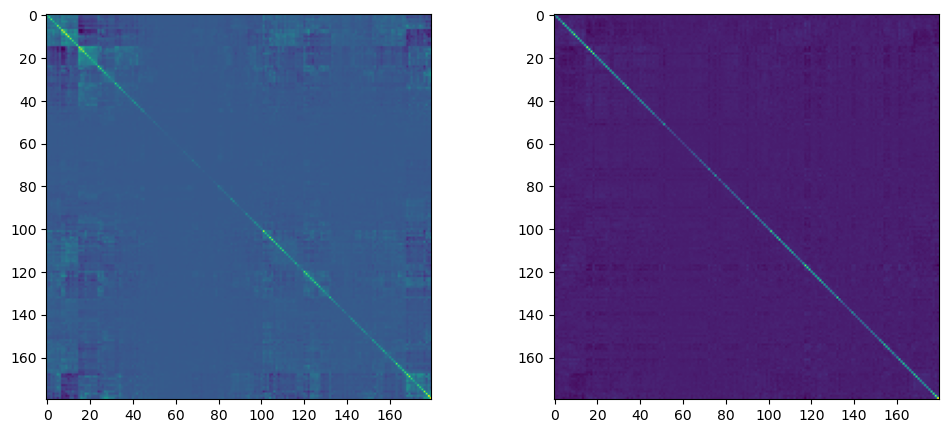

PyObject <matplotlib.image.AxesImage object at 0x226e792b0>

In [521]:
fig, ax = PyPlot.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax[1].imshow(cmat[order,order])
ax[2].imshow(cmats[order,order])

In [527]:
pcs = prcomps(log.(res2))

 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value


LoadError: LAPACKException(21)

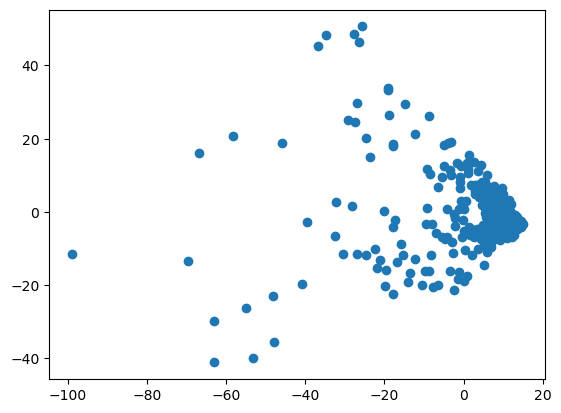

PyObject <matplotlib.collections.PathCollection object at 0x226f1a4c0>

In [524]:
scatter(pcs[:,1],pcs[:,2])

In [534]:
pcs2 = prcomps(log.(x.+ 0.001))

1525×180 Matrix{Float64}:
 -6.7607      3.78503   1.47851    …   0.0798898   1.03221     -0.302657
 -4.87534     2.12612   4.42905       -0.577503    0.624639    -0.876669
  3.16873     1.46465   0.577542      -0.441455    0.0181925    0.0141353
 -5.52013     1.53577   1.09081       -0.624138    0.302009    -0.078412
 -4.89285     3.15643   1.55876       -0.142089   -1.42525      1.07858
  1.11563     1.66786  -0.788579   …   0.146198    0.973817    -0.382751
  0.0896056   1.27925  -2.08003       -0.0413121   0.120228    -0.239961
  4.63614     1.39996   0.545878       0.712876   -0.025166    -0.779331
  2.46505     1.06231   0.776489      -0.177541    0.573332    -0.223163
  0.82259     1.27354  -3.31862       -0.144756   -1.54125      0.496116
 -1.7557     -3.32988   0.935962   …   0.922003    0.673243     0.548844
  3.03643     1.33908  -0.0820146      0.0371291   0.0609308    0.122978
 -3.53156     2.39943  -0.155897      -0.580117   -0.623337     0.323264
  ⋮                      

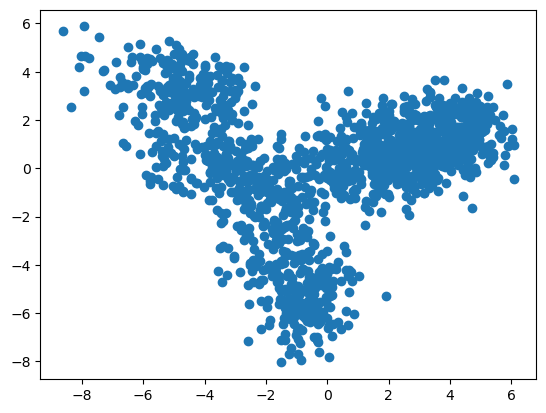

PyObject <matplotlib.collections.PathCollection object at 0x2271b7700>

In [535]:
scatter(pcs2[:,1],pcs2[:,2])

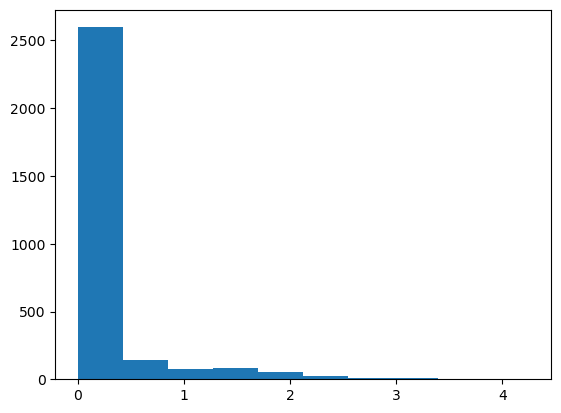

([2597.0, 144.0, 76.0, 81.0, 55.0, 24.0, 13.0, 11.0, 3.0, 1.0], [0.0, 0.42484952420493594, 0.8496990484098719, 1.2745485726148078, 1.6993980968197437, 2.1242476210246797, 2.5490971452296156, 2.9739466694345515, 3.3987961936394875, 3.8236457178444234, 4.248495242049359], (PyObject <matplotlib.patches.Rectangle object at 0x22675df40>, PyObject <matplotlib.patches.Rectangle object at 0x22675ddc0>, PyObject <matplotlib.patches.Rectangle object at 0x22676c430>, PyObject <matplotlib.patches.Rectangle object at 0x22676c640>, PyObject <matplotlib.patches.Rectangle object at 0x22676c850>, PyObject <matplotlib.patches.Rectangle object at 0x22676ca60>, PyObject <matplotlib.patches.Rectangle object at 0x22676cc70>, PyObject <matplotlib.patches.Rectangle object at 0x22676ce80>, PyObject <matplotlib.patches.Rectangle object at 0x22676cfa0>, PyObject <matplotlib.patches.Rectangle object at 0x22677d2e0>))

In [371]:
PyPlot.hist(log.(res2[200,:] .+1))

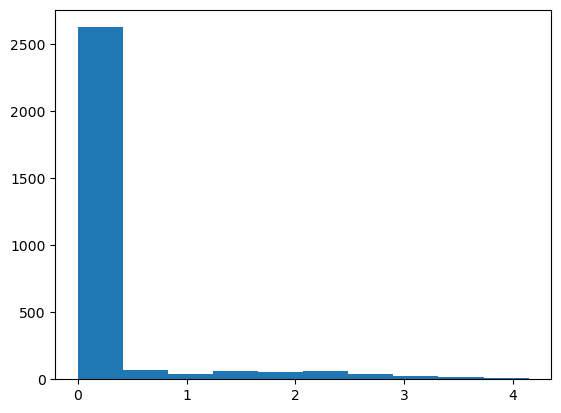

([2626.0, 67.0, 38.0, 64.0, 56.0, 61.0, 43.0, 25.0, 17.0, 8.0], Float32[0.0, 0.41431347, 0.82862693, 1.2429404, 1.6572539, 2.0715673, 2.4858809, 2.9001942, 3.3145077, 3.728821, 4.1431346], (PyObject <matplotlib.patches.Rectangle object at 0x2267dc070>, PyObject <matplotlib.patches.Rectangle object at 0x2267cfeb0>, PyObject <matplotlib.patches.Rectangle object at 0x2267dc520>, PyObject <matplotlib.patches.Rectangle object at 0x2267dc730>, PyObject <matplotlib.patches.Rectangle object at 0x2267dc940>, PyObject <matplotlib.patches.Rectangle object at 0x2267dcb50>, PyObject <matplotlib.patches.Rectangle object at 0x2267dcd60>, PyObject <matplotlib.patches.Rectangle object at 0x2267dcf70>, PyObject <matplotlib.patches.Rectangle object at 0x2267ec1c0>, PyObject <matplotlib.patches.Rectangle object at 0x2267ec3d0>))

In [372]:
PyPlot.hist(log.(x1[:,200].+1))

In [536]:
zs = float.(Transpose(infres[1]))
zs = Transpose(normdist)
xs = float.(Transpose(res3))
zsbin = float.(ifelse.(zs.>0,1,0))

3005×10 Matrix{Float64}:
 1.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  1.0  1.0
 1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0
 1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0
 0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  1.0
 1.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0  0.0  0.0
 1.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0
 0.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0
 0.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0
 1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0
 1.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0
 ⋮                        ⋮                   
 1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0
 1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0
 0.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0  1.0
 1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0
 0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0
 0.0  1.0  0.0  1.0  0.0  0.

In [537]:
xsbin = VarEnc.dichotomize(xs,selquantile=0.9)

3005×180 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.

In [538]:
xsbin2 = VarEnc.dichotomize(Transpose(res2),selquantile=0.9)

1525×180 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  1.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  1.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [539]:
sum(xsbin2,dims=1)

1×180 Matrix{Float64}:
 153.0  153.0  153.0  153.0  153.0  …  150.0  153.0  149.0  148.0  145.0

In [540]:
nvars= 8

8

In [541]:
res = select_k_variables(nvars,[converttoleveldata([xsbin,zsbin])],evolution=true)

([194.49243477137048, 156.236883102644, 161.80656217391663, 138.4881868277738, 92.46436992708283, 81.87150855767159, 75.24901552927871, 76.80646140267372], [87, 100, 49, 15, 150, 155, 105, 153], Any[[3.4853102323833625 0.12029989947576958 … 5.657641951174291 16.509864314479508; 4.610034743697625 0.3479838173360186 … 14.814873344268314 6.128049285948926; … ; 0.010797323386581681 0.4234218000635419 … 1.2146512384275887 10.746649777265176; 3.4853102323833625 0.01940480629412855 … 0.29183006797421385 1.2932330717446874], [3.2195926098477843 1.4194141905736841 … 5.6765694641047215 16.408359755494438; 5.703213217275155 3.5521226076979673 … 15.582512071619389 6.737591414261998; … ; 0.46937306043789473 0.7165066671878864 … 1.068962988733524 15.336417622951615; 3.503164382262465 0.6920398012979052 … 1.0901274357946358 1.3036920263581795], [2.7799594967444694 3.9163433267992223 … 5.906227664403017 16.13672701656978; 5.87094831542774 4.059059586448593 … 16.74514901836266 7.835910068098208; … ; 2.

In [542]:
res[2]

8-element Vector{Int64}:
  87
 100
  49
  15
 150
 155
 105
 153

In [546]:
y = string.(adata.obs["labels"])

3005-element Vector{String}:
 "1"
 "1"
 "1"
 "1"
 "1"
 "1"
 "1"
 "1"
 "1"
 "1"
 "1"
 "1"
 "1"
 ⋮
 "6"
 "6"
 "6"
 "6"
 "6"
 "6"
 "6"
 "6"
 "6"
 "6"
 "6"
 "6"

In [462]:
countmap(adata.obs["labels"])

Dict{Int64, Int64} with 7 entries:
  5 => 98
  4 => 820
  6 => 235
  7 => 224
  2 => 399
  3 => 939
  1 => 290

In [463]:
xbin = VarEnc.dichotomize(x1,selquantile=0.7) 


3005×300 Matrix{Float64}:
 1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  …  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  1.0  0.0  0.0
 1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  1.0  1.0  0.0
 1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  1.0  0.0  0.0
 1.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  1.0  0.0  0.0
 1.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0  …  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.

In [545]:
yhat = annotatesamplesbypattern(xbin,xsbin[1:1000,:],res[2],y)

LoadError: BoundsError: attempt to access 1525-element Vector{Any} at index [1526]

In [465]:
[string(i) for i =xsbin[1:1000,res[2]]]

1000×8 Matrix{String}:
 "1.0"  "0.0"  "0.0"  "1.0"  "0.0"  "1.0"  "0.0"  "0.0"
 "1.0"  "0.0"  "0.0"  "1.0"  "1.0"  "0.0"  "1.0"  "0.0"
 "1.0"  "0.0"  "0.0"  "1.0"  "1.0"  "0.0"  "0.0"  "0.0"
 "1.0"  "1.0"  "1.0"  "1.0"  "0.0"  "1.0"  "0.0"  "0.0"
 "1.0"  "0.0"  "1.0"  "1.0"  "1.0"  "0.0"  "0.0"  "1.0"
 "1.0"  "0.0"  "0.0"  "1.0"  "0.0"  "1.0"  "0.0"  "0.0"
 "0.0"  "0.0"  "1.0"  "0.0"  "0.0"  "0.0"  "1.0"  "0.0"
 "0.0"  "0.0"  "0.0"  "1.0"  "1.0"  "0.0"  "0.0"  "0.0"
 "1.0"  "1.0"  "0.0"  "0.0"  "0.0"  "0.0"  "1.0"  "0.0"
 "1.0"  "0.0"  "0.0"  "0.0"  "1.0"  "0.0"  "0.0"  "1.0"
 "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "1.0"  "0.0"  "0.0"
 "0.0"  "0.0"  "1.0"  "1.0"  "0.0"  "0.0"  "0.0"  "1.0"
 "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"  "0.0"
 ⋮                                  ⋮             
 "1.0"  "1.0"  "0.0"  "0.0"  "1.0"  "1.0"  "0.0"  "0.0"
 "0.0"  "0.0"  "1.0"  "0.0"  "0.0"  "0.0"  "0.0"  "1.0"
 "0.0"  "0.0"  "1.0"  "0.0"  "0.0"  "0.0"  "0.0"  "1.0"
 "0.0"  "0.0"  "0.0"  "1.0"  "

In [466]:
countmap(yhat)

Dict{String, Int64} with 7 entries:
  "4" => 140
  "1" => 38
  "5" => 73
  "2" => 57
  "6" => 234
  "7" => 326
  "3" => 132

In [467]:
md = Dict(
    "1"    => "turquoise",
  "2"   => "darkviolet",
  "3"   => "gold",
  "4"   => "forestgreen",
  "5" => "orangered",
  "6"    => "green",
  "7"   => "lightgrey")

Dict{String, String} with 7 entries:
  "4" => "forestgreen"
  "1" => "turquoise"
  "5" => "orangered"
  "2" => "darkviolet"
  "6" => "green"
  "7" => "lightgrey"
  "3" => "gold"

In [468]:
hatcols = [md[i] for i = yhat]

1000-element Vector{String}:
 "green"
 "forestgreen"
 "orangered"
 "gold"
 "lightgrey"
 "green"
 "forestgreen"
 "lightgrey"
 "forestgreen"
 "lightgrey"
 "green"
 "gold"
 "green"
 ⋮
 "green"
 "gold"
 "gold"
 "lightgrey"
 "lightgrey"
 "forestgreen"
 "orangered"
 "lightgrey"
 "gold"
 "lightgrey"
 "lightgrey"
 "gold"

In [469]:
countmap(hatcols)

Dict{String, Int64} with 7 entries:
  "gold"        => 132
  "lightgrey"   => 326
  "darkviolet"  => 57
  "forestgreen" => 140
  "green"       => 234
  "orangered"   => 73
  "turquoise"   => 38

In [470]:
pcs = prcomps(xsbin)

3005×300 Matrix{Float64}:
  6.8091    -2.65524    -3.86147    …   0.566899    0.143231    1.04885
  4.98486   -2.82001    -8.33212       -1.1998     -0.425465    0.290582
 10.5841     1.17259    -8.40277        0.525736   -0.519166   -0.538746
  5.31054   -3.7248      4.26174       -0.835576   -0.273195   -0.0580605
  4.06587   -0.0390823   3.50229        0.674837    0.0598002  -0.25697
  4.07898    2.06815    -1.24795    …   0.219202   -0.588791    0.959817
  3.96142    1.36499    -0.546275      -1.25588    -0.557517   -0.563264
  5.52861    0.574202    0.858188       0.276919   -1.69888     1.23926
  6.04424   -3.48293     4.25337       -0.233604   -0.221618    0.13345
  6.19036   -3.09755    -6.82776       -0.079533    0.529609    0.589679
  5.20504   -1.45737    -3.47442    …  -1.18104    -0.321416   -0.0944305
  5.28262    1.81893    -0.913888      -0.860218   -0.333306    0.720242
  5.49642   -1.39171    -6.08742        0.589342    0.256511   -0.400296
  ⋮                        

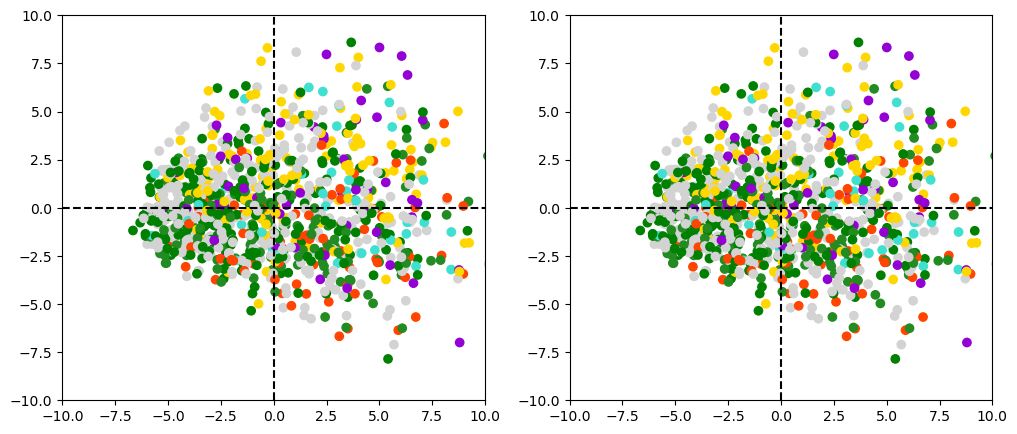

PyObject <matplotlib.lines.Line2D object at 0x226dca220>

In [471]:
fig, ax = PyPlot.subplots(nrows=1, ncols=2, figsize=(12, 5))
scalepar = 10
ax[1].scatter(pcs[1:1000,1],pcs[1:1000,2],c=hatcols)
ax[1].set_xlim(-scalepar,scalepar)
ax[1].set_ylim(-scalepar,scalepar)
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")
ax[2].scatter(pcs[1:1000,1],pcs[1:1000,2],c=hatcols)
ax[2].set_xlim(-scalepar,scalepar)
ax[2].set_ylim(-scalepar,scalepar)
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")